In [1]:
from sklearn.datasets import load_sample_image
import tensorflow as tf
from keras.layers import Conv2D

import matplotlib.pyplot as plt
import numpy as np

합성곱층
 - CNN의 가장 주용한 구성 요소는 합성곱 층
 - 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱층 뉴런의 수용장 안에 있는 픽셀에만 연결
 - 첫번째 은닉층에서는 작은 저수준 특성에 집중, 다음 은닉층에서는 더 큰 고수준 특성으로 조합

#### 텐서플로 구현

In [2]:
#데이터 불러오기
china = load_sample_image("china.jpg") / 255 #픽셀강도 0~255사이의 값을 가진 바이트 하나로 표현
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

tf.nn.conv2d()
- Images는 입력의 미니배치(4D텐서)
- filters는 적용될 일련의 필터(4D텐서)
- strides는 1이나 4개의 원소를 갖는 1D 배열로 지정할 수 있음
- 1D 배열의 가운데 두 개의 원소는 수직, 수평 스트라이드이고, 현재는 첫번째 마지막 원소가 1이여야함
- 언젠가 배치 스트라이드(일부 샘플 건너뛰기 위해)와 채널 스트라이드(이전층의 특성 맵이나 채널을 건너뛰기 위해)를 지정하는데 사용될지 모름
- Paddingdms VALID와 SAME 둘중 하나 지정
- VALID로 지정하면 제로패딩 사용 안함 스트라이드 입력에 따라 이미지 아래 오른쪽 행과 열이 무시될 수 있음
- SAME은 제로패딩 사용 입력 크기가 13이고 출력크기는 입력 뉴런 수를 스트라이드로 나누어 올림한 것 과 같음, 필요하면 입력데이터 주변에 가능한 동일하게 0이 추가

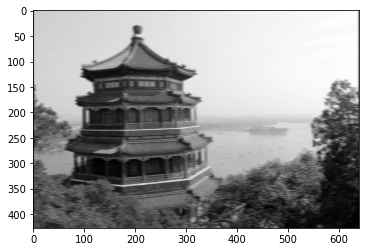

In [3]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype= np.float32) #7*7 필터 만들기
filters[:,3, :,0] = 1 #수직
filters[3,:,:,1] = 1 #수평
outputs = tf.nn.conv2d(images, filters, strides=1, padding = "SAME") #2가지필터를 두 이미지에 적용
plt. imshow(outputs[0,:,:,1], cmap = "gray") # 첫 번째 이미지의 두번째 특성 맵을 그림
plt.show()

In [4]:
#많은 하이퍼파라미터 필요하나 정확한 값을 찾으려면 교차검증 사용해야함
conv = tf.keras.layers.Conv2D(filters =32, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')

#### 메모리요구사항
- 합성곱 층이 많은 양의 RAM을 필요로함
- 메모리 부족으로 훈련이 실패한다면 미니배치로 크기 줄이기 또는 스트라이드를 사용하여 차원줄이거나 몇개층을 제거
- 32비트 부동소수 대신 16비트 부동소수를 사용 아미녀 여러장치에 CNN 분산

#### 풀링층
- 목적은 계산량과 메모리사용량, 파라미터수를 줄이기 위해 입력 이미지의 부표본을 만드는것
- 합성곱 층에서와 마찬가지로 풀링 층의 각 뉴런은 이전 층의 작은 사각영역의 수용장 안에 있는 뉴런의 출력과 연결
- 크기, 스트라이드, 패딩 유형을 지정해야함 풀링뉴런은 가중치가 없음, 최대나 평균 같은 합산 함수를 사용해 입력값을 더하는 것이 전부
- 풀링 층은 보통 모든 입력 채널에 독립적으로 적용되므로 출력, 입력 깊이 동일

#### 최대풀링층
 - 계산량, 메모리 사용량, 파라미터 수 감소 
 - 작은 변화에도 일정 수준의 불변성 만들어줌
 - 층을 추가하면 전체적으로 일정 수준의 이동 불변성을 얻을 수 있음
 - 회전과 확대 축소에 대해서 약간의 불변성을 제공
 - 불변성은 분류 작업처럼 예측이 이런작은 부분에서 영향을 받지 않는 경우 유용
 - 매우 파괴적이라는 단점, 출력은 양방향으로 절반이 줄어들어 입력값의 75%를 잃을수도 잇음
 - 애플리케이션에서 불변성이 필요하지 않음(시맨틱 분활)

#### 평균풀링층
- MAXPool2D 대신 AvgPool2D 사용
- 평균을 계산하는 것만 빼고 최대 풀링 층과 동일하게 작동
- 최대 풀링 층이 일반적으로 성능이 더 좋음
- 최대풀링 층 보다 정보 손실이 적음, 더 명확한 신호로 작업 가능

#### 텐서플로 구현

In [9]:
max_pool = tf.keras.layers.MaxPool2D(pool_size = 2)

In [11]:
output = tf.nn.max_pool(images, ksize = (1,1,1,3),
                        strides = (1,1,1,3),
                        padding = "VALID")

In [14]:
#케라스 모델의 층으로 사용하려면 lambda층으로 감싸면 됨
depth_pool = tf.keras.layers.Lambda(
    lambda X : tf.nn.max_pool(X, ksize =(1,1,1,3), strides = (1,1,1,3),
                              padding = "VALID"))

#### 전역평균풀링층
- 각 특성 맵의 평균을 꼐산
- 샘플의 특성 맵마다 하나의 숫자를 출력한다는 의미
- 매우파괴적인 연산이지만 출력층에는 유용
- keras.layers.GlobalAvgPool2D 클래스 사용

In [15]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [16]:
global_avg_pool = tf.keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1,2]))

#### CNN의 구조